# Convert a JAX Model to OpenVINO™ IR

[JAX](https://jax.readthedocs.io/en/latest) is a Python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning.
JAX provides a familiar NumPy-style API for ease of adoption by researchers and engineers.


In this tutorial we will show how to convert JAX [ViT](https://github.com/google-research/vision_transformer?tab=readme-ov-file#available-vit-models) and [Mixer](https://github.com/google-research/vision_transformer?tab=readme-ov-file#mlp-mixer) models in OpenVINO format.

<details>
  <summary><b>Click here for more detailed information about the models </b></summary>

### Vision Transformer
<img src="https://github.com/google-research/vision_transformer/blob/main/vit_figure.png?raw=true" width="800"> 

Overview of the model: authors split an image into fixed-size patches, linearly embed each of them, add position embeddings, and feed the resulting sequence of vectors to a standard Transformer encoder. In order to perform classification, authors use the standard approach of adding an extra learnable "classification token" to the sequence.

### MLP-Mixer
<img src="https://github.com/google-research/vision_transformer/blob/main/mixer_figure.png?raw=true" width="800"> 

MLP-Mixer (Mixer for short) consists of per-patch linear embeddings, Mixer layers, and a classifier head. Mixer layers contain one token-mixing MLP and one channel-mixing MLP, each consisting of two fully-connected layers and a GELU nonlinearity. Other components include: skip-connections, dropout, and linear classifier head.

</details>

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Load and run the original model and a sample](#Load-and-run-the-original-model-and-a-sample)
- [Convert the model to OpenVINO IR](#Convert-the-model-to-OpenVINO-IR)
- [Compiling the model](#Compiling-the-model)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)

### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/jax-to-openvino/jax-classification-to-openvino.ipynb" />

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import requests


r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py",
)
open("cmd_helper.py", "w").write(r.text)

In [ ]:
from cmd_helper import clone_repo


clone_repo("https://github.com/google-research/vision_transformer.git")

In [ ]:
%pip install --pre -Uq "openvino>=2024.5.0" --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly
%pip install -q "tensorflow-macos>=2.5 jax-metal>=0.4.2"; sys_platform == 'darwin' and platform_machine == 'arm64'" # macOS M1 and M2
%pip install -q "tensorflow>=2.5 jax>=0.4.2"; sys_platform == 'darwin' and platform_machine != 'arm64'" # macOS x86
%pip install -q "tensorflow-cpu>=2.5 jax>=0.4.2"; sys_platform != 'darwin'"
%pip install -q Pillow "absl-py>=0.12.0" "flax>=0.6.4" "pandas>=1.1.0" tf_keras tqdm "einops>=0.3.0" "ml-collections>=0.1.0"

In [4]:
import PIL
import jax
import numpy as np

from vit_jax import checkpoint
from vit_jax import models_vit
from vit_jax import models_mixer
from vit_jax.configs import models as models_config

import openvino as ov

In [5]:
import ipywidgets as widgets

available_models = ["ViT-B_32", "Mixer-B_16"]


model_to_use = widgets.Select(
    options=available_models,
    value=available_models[0],
    description="Select model:",
    disabled=False,
)

model_to_use

Select(description='Select model:', options=('ViT-B_32', 'Mixer-B_16'), value='ViT-B_32')

## Load and run the original model and a sample
[back to top ⬆️](#Table-of-contents:)

Download a pre-trained model.

In [6]:
from notebook_utils import download_file


model_name = model_to_use.value
model_config = models_config.MODEL_CONFIGS[model_name]


if model_name.startswith("Mixer"):
    # Download model trained on imagenet2012
    model_name_path = download_file(f"https://storage.googleapis.com/mixer_models/imagenet1k/{model_name}.npz", filename=f"{model_name}_imagenet2012.npz")
    model = models_mixer.MlpMixer(num_classes=1000, **model_config)
else:
    # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
    model_name_path = download_file(
        f"https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/{model_name}.npz", filename=f"{model_name}_imagenet2012.npz"
    )
    model = models_vit.VisionTransformer(num_classes=1000, **model_config)

ViT-B_32_imagenet2012.npz:   0%|          | 0.00/337M [00:00<?, ?B/s]

Load and convert pretrained checkpoint.

In [7]:
params = checkpoint.load(f"{model_name}_imagenet2012.npz")
params["pre_logits"] = {}  # Need to restore empty leaf for Flax.

Get imagenet labels.

In [8]:
from notebook_utils import download_file


imagenet_labels_path = download_file("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt")
imagenet_labels = dict(enumerate(open(imagenet_labels_path)))

ilsvrc2012_wordnet_lemmas.txt:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

Get a random picture with the correct dimensions.

In [29]:
resolution = 224 if model_name.startswith("Mixer") else 384
image_path = download_file(f"https://picsum.photos/{resolution}", filename="picsum.jpg")
img = PIL.Image.open(image_path)

picsum.jpg:   0%|          | 0.00/30.5k [00:00<?, ?B/s]

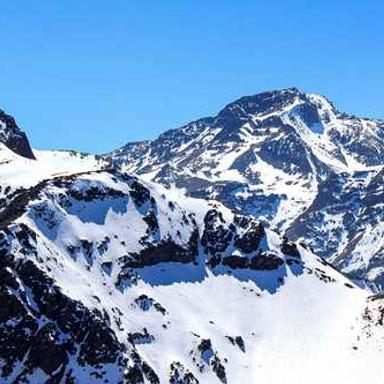

In [30]:
img

### Run the original model inference

In [31]:
# Predict on a batch with a single item (note very efficient TPU usage...)
data = (np.array(img) / 128 - 1)[None, ...]
(logits,) = model.apply(dict(params=params), data, train=False)

preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
    print(f"{preds[idx]:.5f} : {imagenet_labels[idx]}", end="")

0.95251 : alp
0.03884 : valley, vale
0.00192 : cliff, drop, drop-off
0.00173 : ski
0.00059 : lakeside, lakeshore
0.00049 : promontory, headland, head, foreland
0.00036 : volcano
0.00021 : snowmobile
0.00017 : mountain_bike, all-terrain_bike, off-roader
0.00017 : mountain_tent


## Convert the model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

OpenVINO supports JAX models via conversion to OpenVINO Intermediate Representation (IR). [OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original JAX model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`.

Before conversion we need to create the [`Jaxprs`](https://jax.readthedocs.io/en/latest/key-concepts.html#jaxprs) (JAX's internal intermediate representation (IR) of programs) object by tracing a Python function using the [`jax.make_jaxpr`](https://jax.readthedocs.io/en/latest/_autosummary/jax.make_jaxpr.html) function. [`jax.make_jaxpr`] take a function as argument, that should perform the forward pass. In our case it is calling of `model.apply` method. But `model.apply` requires not only input data, but also `params` and keyword argument `train=False` in our case. To handle it create a wrapper function  `model_apply` that calls `model.apply(params, x, train=False)`.

In [32]:
from pathlib import Path


model_path = Path(f"models/{model_name}.xml")


def model_apply(x):
    return model.apply(dict(params=params), x, train=False)


jaxpr = jax.make_jaxpr(model_apply)((np.array(img) / 128 - 1)[None, ...])

converted_model = ov.convert_model(jaxpr)
ov.save_model(converted_model, model_path)

## Compiling the model
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO.

In [33]:
from notebook_utils import device_widget


core = ov.Core()

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [34]:
compiled_model = core.compile_model(model_path, device.value)

## Run OpenVINO model inference

In [35]:
(logits_ov,) = list(compiled_model(data).values())[0]

preds = np.array(jax.nn.softmax(logits_ov))
for idx in preds.argsort()[:-11:-1]:
    print(f"{preds[idx]:.5f} : {imagenet_labels[idx]}", end="")

0.95255 : alp
0.03881 : valley, vale
0.00192 : cliff, drop, drop-off
0.00173 : ski
0.00059 : lakeside, lakeshore
0.00049 : promontory, headland, head, foreland
0.00036 : volcano
0.00021 : snowmobile
0.00017 : mountain_bike, all-terrain_bike, off-roader
0.00017 : mountain_tent


In [ ]:
# Cleanup
# %pip uninstall -q -y "tensorflow-cpu" tensorflow tf_keras